In [1]:
import pandas as pd
import datarobot as dr
import os
from sklearn.metrics import roc_auc_score, log_loss, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

source_data_file = 'data/Horizon-Delay Dataset.csv'

# Read in data from .csv
df_full = pd.read_csv(source_data_file)

# Shuffle the rows
df_full = df_full.sample(frac=1, random_state=0)

# Split 90% for training, 10% for predictions
split = int(df_full.shape[0] * .1)
df = df_full[split:]
df_pred = df_full[:split].copy()\

# Drop the target from the prediction dataset
prediction_data = df_pred.drop('DELAY_INDICATOR', axis=1)

print('Full data shape:      ',df_full.shape)
print('Training data shape:  ',df.shape)
print('Prediction data shape:',prediction_data.shape)

Full data shape:       (418060, 15)
Training data shape:   (376254, 15)
Prediction data shape: (41806, 14)


# DataRobot API example

### Create a DataRobot project

In [2]:
# Establish client connection
dr.Client(token=os.environ['DATAROBOT_API_TOKEN'], endpoint='https://app.datarobot.com/api/v2')

### As you see in the DataRobot user interface under the Predict tab, If we wanted to call a project and model, say for predictions, we just need the project and model ID.

In [3]:
# PROJECT_ID = '5afde3c76cd83a095b959bb8'
# MODEL_ID = '5afde7fdb79b5a2d7bb067ff'

# project = dr.Project.get(PROJECT_ID)
# model = dr.Model.get(PROJECT_ID, MODEL_ID)

# # Upload dataset to make predictions
# pred_dataset = project.upload_dataset(prediction_data)

# # Make predictions on your data
# pred_job = model.request_predictions(pred_dataset.id)
# predictions = pred_job.get_result_when_complete()
# for row in predictions.iterrows():
#     print(row)

### The 'Out of the Box Autopilot'
#### If we wanted to run autopilot on the uploaded dataset and features as is, then we would simply run project.start, which only needs the source data (eg, a csv), the target name, and a project name as parameters.
```
project.start(sourcedata=df, 
              target='DELAY_INDICATOR'
              project_name='Horizon flght delay classification'
```
#### Instead, we'll manually create a project, use our derived feature list, select a blueprint to run

In [4]:
# # Create a project: and upload the data, set the target, give the project a name
project = dr.Project.create(sourcedata=df, 
                            project_name='Horizon Flight Delay API example')

print('project id:', project.id)
print('project name:', project.project_name)
print('project.get_status():', project.get_status())

project id: 5aff005f6cd83a4ae78a5230
project name: Horizon Flight Delay API example
project.get_status(): {'autopilot_done': False, 'stage_description': 'Ready to set target', 'stage': 'aim'}


### Working with features:

In [5]:
# Output the identified project features
features = project.get_features()
sorted([f.name for f in features])

['ACT_AC_TYPE',
 'ARRV_A15_IND',
 'AVOIDABLE_DELAY_IND',
 'CARRIER',
 'DAY_OF_WEEK',
 'DELAY_CODE',
 'DELAY_CODE_DESCRIPTION',
 'DELAY_INDICATOR',
 'DESTINATION',
 'D_O_W_NUM',
 'FLT_DATE',
 'FLT_DATE (Day of Week)',
 'FLT_NBR',
 'HOUR_OF_DPTR',
 'ORIGIN',
 'UNAVOIDABLE_DELAY_IND']

In [6]:
# Convert flight number to a categorical variable
new_feature = project.create_type_transform_feature(name='FLT_NBR_CAT', 
                                      parent_name='FLT_NBR', 
                                      variable_type='categoricalInt')
new_feature

Feature(FLT_NBR_CAT)

In [7]:
# Create a new feature list from our subset of features to eliminate target leaks
# new_list = [c for c in df_less_5.columns] + [new_feature.name]
new_list = ['DELAY_INDICATOR', 'ORIGIN', 'DESTINATION', 'CARRIER', 
            'DAY_OF_WEEK', 'HOUR_OF_DPTR', 'ACT_AC_TYPE', new_feature.name]
f_list = project.create_featurelist('No leaks list', new_list)
f_list

Featurelist(No leaks list)

### Kickoff the project

In [8]:
# By calling set_target, we run datarobot
project.set_target(target='DELAY_INDICATOR', 
                   mode='auto',
                   worker_count=20,
                   featurelist_id=f_list.id)

Project(Horizon Flight Delay API example)

### Get models and blueprints from the leaderboard

In [12]:
# Get the models, which are already in rank order from the leaderboard
models = project.get_models()

# Get the best performing model
best_model = models[4]
print('Best model from the leaderboard:\n-',best_model)
print()

# Get the model metrics
print('best_model.metrics:')
pprint(best_model.metrics)

# Get the blueprint
blueprint_id = best_model.blueprint_id
blueprint = dr.models.Blueprint.get(project.id, blueprint_id)
print('Blueprint:')
print('- id:',blueprint.id)
print('- model:',blueprint.model_type)
print('- blueprint category:',blueprint.blueprint_category)
print('- blueprint preprocesses:')
pprint(blueprint.processes)

Best model from the leaderboard:
- Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping (Fast Feature Binning)')

best_model.metrics:
{'AUC': {'backtesting': None,
         'backtestingScores': None,
         'crossValidation': None,
         'holdout': None,
         'validation': 0.7039},
 'FVE Binomial': {'backtesting': None,
                  'backtestingScores': None,
                  'crossValidation': None,
                  'holdout': None,
                  'validation': 0.09393},
 'Gini Norm': {'backtesting': None,
               'backtestingScores': None,
               'crossValidation': None,
               'holdout': None,
               'validation': 0.4078},
 'Kolmogorov-Smirnov': {'backtesting': None,
                        'backtestingScores': None,
                        'crossValidation': None,
                        'holdout': None,
                        'validation': 0.29773},
 'LogLoss': {'backtesting': None,
             'backtestingScores'

### Make predictions

In [13]:
# Upload the scoring dataset
dataset = project.upload_dataset(prediction_data)

# Make a call to request predictions using the best model
predict_job = best_model.request_predictions(dataset.id)

In [14]:
# Get our predictions results
predictions = predict_job.get_result_when_complete()
predictions.head()

,positive_probability,prediction,row_id,class_0.0,class_1.0
0,0.246674,0.0,0,0.753326,0.246674
1,0.169382,0.0,1,0.830618,0.169382
2,0.603128,1.0,2,0.396872,0.603128
3,0.760564,1.0,3,0.239436,0.760564
4,0.252177,0.0,4,0.747823,0.252177


In [15]:
predictions['y_true'] = df_pred.DELAY_INDICATOR.astype(int)
predictions['y_true'].fillna(0, inplace=True)
predictions.head()

,positive_probability,prediction,row_id,class_0.0,class_1.0,y_true
0,0.246674,0.0,0,0.753326,0.246674,0.0
1,0.169382,0.0,1,0.830618,0.169382,0.0
2,0.603128,1.0,2,0.396872,0.603128,0.0
3,0.760564,1.0,3,0.239436,0.760564,0.0
4,0.252177,0.0,4,0.747823,0.252177,0.0


In [16]:
acc_amt = predictions[predictions.prediction == predictions.y_true].shape[0]
acc_amt

29764

In [17]:
accuracy = acc_amt*1. / predictions.shape[0]
accuracy

0.7119552217385064

In [18]:
auc = roc_auc_score(predictions.y_true, predictions['class_1.0'])
auc

0.48926281892529033

In [19]:
logloss = log_loss(predictions.y_true, predictions['class_1.0'])
logloss

0.5703352881323852

In [23]:
pred_copy = predictions.copy()

In [45]:
p_sort = predictions.sort_values('y_true').astype(int)

In [46]:
y_true = p_sort.y_true.values
y_true

array([0, 0, 0, ..., 1, 1, 1])

In [47]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

Automatically created module for IPython interactive environment


In [50]:
y_true[:10]
# iris.target[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

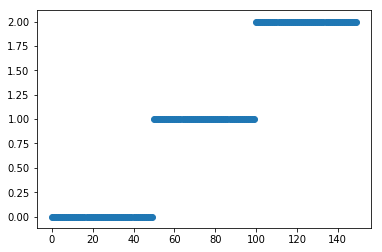

In [60]:
_y = y_true
_y = iris.target
plt.scatter(range(_y.shape[0]), _y)

In [61]:
# Compute ROC curve and ROC area for each class
# Binarize the output
y = label_binarize(_y, classes=[0, 1])
n_classes = y.shape[1]
y_score = predictions[['class_0.0','class_1.0']]
y

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0,

In [32]:
# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1])
y

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0,

In [32]:
# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

Automatically created module for IPython interactive environment


In [45]:
ys = predictions[['class_0.0','class_1.0']]
np.array(ys)

array([[0.60261348, 0.39738652],
       [0.82809225, 0.17190775],
       [0.46891129, 0.53108871],
       ...,
       [0.42987001, 0.57012999],
       [0.43995923, 0.56004077],
       [0.56137219, 0.43862781]])

In [48]:
y

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [75]:
y = predictions['y_true'].astype(int).values
type(y)
type(iris.target)

numpy.ndarray

In [71]:
y = iris.target
# y = predictions['y_true'].astype(int)

# Binarize the output
y = label_binarize(y, classes=[0, 1])
y

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0,

In [38]:
predictions.

array([[-0.76305896, -0.36472635,  0.1239796 ],
       [-0.20238399, -0.63148982, -0.16616656],
       [ 0.11808492, -0.80262259, -0.32062486],
       [-0.90750303, -0.1239792 ,  0.02184016],
       [-0.01108555, -0.27918155, -0.71882525],
       [-0.60521037, -0.34728075, -0.05851787],
       [ 0.02264569, -0.24507866, -0.79094201],
       [-0.61115098,  0.1827259 , -0.57154703],
       [-0.37590649, -0.24062697, -0.38892819],
       [-0.47019698, -0.25733679, -0.27501927],
       [-0.42194767, -0.30275351, -0.28027547],
       [-0.33545871, -0.70306393,  0.02538619],
       [-0.22711497, -0.64064389, -0.13452752],
       [-0.07836815, -0.46342889, -0.45930643],
       [-0.533757  , -0.26521263, -0.20026826],
       [ 0.09973063, -0.55326984, -0.56156984],
       [-0.71354879, -0.04231832, -0.24317009],
       [-0.55067912, -0.13785396, -0.31413579],
       [ 0.37989555, -0.99673681, -0.3909524 ],
       [-0.11088917, -0.91357544,  0.03129667],
       [-0.70721114, -0.06430956, -0.214